In [197]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
tf.enable_eager_execution()

In [187]:
%matplotlib inline

# Introduction

<p>Following Marin, Pudlo, & Etroup (2019), we will construct a toy model selection example consisting of three unidimensional models with tractable marginal likelihoods.</p>

1. Model 1 is an exponential distribution with rate parameter  $\lambda$
2. Model 2 is a log-normal distribution with location parameter $\mu$ and fixed scale parameter $\sigma = 1$
3. Model 3 is a gamma distribution with parameters $\alpha = 2$ (shape) and $\beta$ (rate)
<p>To do - marginal likelihoods</p>

# Model definitions

In [60]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, h_dim, n_dense=3):
        """
        Creates an invariant function with mean pooling.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        """
        
        super(InvariantModule, self).__init__()
        
        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(h_dim, activation='elu', kernel_initializer='glorot_uniform') 
            for _ in range(n_dense)
        ])

        self.post_pooling_dense = tf.keras.layers.Dense(h_dim, activation='elu', kernel_initializer='glorot_uniform')   
        
    def call(self, x):
        """
        Transofrms the input into an invariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.module(x)
        x = tf.reduce_mean(x, axis=1)
        out = self.post_pooling_dense(x)
        return out
    

class EquivariantModule(tf.keras.Model):
    """Implements an equivariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, h_dim, n_dense=3):
        """
        Creates an equivariant neural network consisting of a FC network with
        equal number of hidden units in each layer and an invariant module
        with the same FC structure.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        """
        
        super(EquivariantModule, self).__init__()
        
        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(h_dim, activation='elu') 
            for _ in range(n_dense)
        ])
        
        self.invariant_module = InvariantModule(h_dim, n_dense)
        
    def call(self, x):
        """
        Transofrms the input into an equivariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x_inv = self.invariant_module(x)
        x_inv = tf.stack([x_inv] * int(x.shape[1]), axis=1) # Repeat x_inv n times
        x = tf.concat((x_inv, x), axis=-1)
        out = self.module(x)
        return out
    

class InvariantNetwork(tf.keras.Model):
    """
    Implements a network which parameterizes a 
    permutationally invariant function according to Bloem-Reddy and Teh (2019).
    """

    def __init__(self, h_dim, n_dense=3, n_equiv=2):
        """
        Creates a permutationally invariant network 
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        n_equiv : int -- the number of equivariant modules 
        """
        
        super(InvariantNetwork, self).__init__()
        
        self.equiv = tf.keras.Sequential([
            EquivariantModule(h_dim, n_dense)
            for _ in range(n_equiv)
        ])
        self.inv = InvariantModule(h_dim, n_dense)
        
    def call(self, x, **kwargs):
        """
        Transofrms the input into a permutationally invariant 
        representation by first passing it through multiple equivariant 
        modules in order to increase representational power.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 
        'samples' dimensions over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.equiv(x)
        out = self.inv(x)
        return out

    
class ModelSelector(tf.keras.Model):
    
    def __init__(self, n_models=3, inv_h_dim=32, n_dense_inv=2, n_equiv=2):
        super(ModelSelector, self).__init__()
        
        self.inv = InvariantNetwork(inv_h_dim, n_dense_inv, n_equiv)
        self.selector = tf.keras.layers.Dense(n_models, activation='relu')
        self.K = n_models
        
    def call(self, x):
        
        x = self.inv(x)
        evidence = self.selector(x)
        alpha = evidence + 1
        S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
        belief = evidence / S_alpha
        uncertainty = self.K / S_alpha
        probs = alpha / S_alpha
        return evidence, alpha, belief, uncertainty, probs

# Utility functions

In [261]:
def plot_dirichlet_samples(model, data_gen, m_samples, labels, n_val=36, figsize=(15, 9)):
    """Plots model probabilities."""
    
    X_test, m_test = data_gen(n_val)
    evidence, alpha, belief, uncertainty, probs = model(X_test)
    m_test = tf.math.argmax(m_test, axis=1).numpy()
    alpha = alpha.numpy()
    probs = probs.numpy()

    f, axarr = plt.subplots(int(np.sqrt(n_val)), int(np.sqrt(n_val)), figsize=figsize)

    for i, ax in enumerate(axarr.flat):
        
        # Sample model probabilities
        s = np.random.dirichlet(alpha[i], m_samples)
        
        # Plot model probabilites
        for k in range(model.K):
            
            # Plot dirichlet samples
            sns.distplot(s[:, k], ax=ax, label=labels[k])
        
        if i == 0:
            ax.legend(fontsize=7)
            
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title('True: {}'.format(labels[m_test[i]]))


    f.tight_layout()

In [ ]:
def xy2bc(xy, tol=1.e-3):
    """
    Convert 2D Cartesian coordinates to barycentrics.
    """
    
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def draw_dir_pdf_contours(p, alpha, nlevels=200, subdiv=8, **kwargs):
    """
    Draws the dirichlet pdf contours.
    """
    
    # Mid-points of triangle sides opposite of each corner
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 for i in range(3)]
    
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dir_pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

def dir_pdf(p, alpha):
    """Returns the pdf for the dirichlet simplex."""
    
    Z = np.gamma(np.sum(alpha)) / np.prod(np.gamma(alpha))
    return Z * np.prod(np.pow(p, alpha-1))


## Losses

In [100]:
def KL_dirichlet(alpha, K):
    """
    Computes the KL divergence between a Dirichlet distribution 
    with parameter vector alpha and a uniform distribution.
    """
    
    beta = tf.constant(np.ones((1, K)), dtype=tf.float32)
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    
    kl = tf.reduce_sum((alpha - beta) * (tf.digamma(alpha) - tf.digamma(S)), axis=1, keepdims=True) + \
         tf.lgamma(S) - tf.reduce_sum(tf.lgamma(alpha), axis=1, keepdims=True) + \
         tf.reduce_sum(tf.lgamma(beta), axis=1, keepdims=True) - tf.lgamma(tf.reduce_sum(beta, axis=1, keepdims=True)
                                                                          )
    kl = tf.reduce_mean(kl)
    return kl

def ml_loss(m_true, alpha, K):
    
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    pred_mean = tf.reduce_sum((m_true - (alpha / S))**2, axis=1, keepdims=True)
    pred_var = tf.reduce_sum(alpha * (S - alpha) / (S * S * (S + 1)), axis=1, keepdims=True)
    loglikelihood = tf.reduce_mean(pred_mean + pred_var)
    return loglikelihood

## Data generator

In [101]:
def generate_data(batch_size, n_points, to_tensor=True):
    
    
    # Make sure a model is nor oversampled
    batch_size_m = batch_size // 3
    batch_sizes = [batch_size_m, batch_size_m, batch_size_m]
    rest_m = batch_size % 3
    bi = np.argmax(np.random.rand(3))
    batch_sizes[bi] += rest_m
    
    # Draw from priors
    exp_scales = 1. / np.random.exponential(scale=1., size=batch_sizes[0])
    logn_means = np.random.normal(loc=0., scale=1., size=batch_sizes[1])
    gamma_scales = 1. /np.random.exponential(scale=1., size=batch_sizes[2])

    # Sample models
    exp_samples = np.random.exponential(scale=exp_scales, size=(n_points, batch_sizes[0])).T
    logn_samples = np.random.lognormal(mean=logn_means, sigma=1., size=(n_points, batch_sizes[1])).T
    gamma_samples = np.random.gamma(shape=2., scale=gamma_scales, size=(n_points, batch_sizes[2])).T
    
    # Stack data
    X_batch = np.r_[exp_samples, logn_samples, gamma_samples]
    m_batch = np.concatenate((np.zeros(batch_sizes[0]), 
                              np.ones(batch_sizes[1]), 
                              np.ones(batch_sizes[2]) + 1)).astype(np.int32)
    
    # Shuffle indices
    shuffle_idx = np.random.permutation(batch_size)
    X_batch = X_batch[shuffle_idx][:, :, np.newaxis]
    m_batch = m_batch[shuffle_idx]
    
    # Convert to one-hot
    m_batch_oh = np.zeros((batch_size, 3))
    m_batch_oh[np.arange(batch_size), m_batch] = 1
    
    if to_tensor:
        X_batch = tf.convert_to_tensor(X_batch, dtype=tf.float32)
        m_batch_oh = tf.convert_to_tensor(m_batch_oh, dtype=tf.float32)
    return X_batch, m_batch_oh

## Epoch loop

In [156]:
def train_loop_online(model, optimizer, data_generator, iterations, batch_size, 
                      X_test, m_test, p_bar, transform=None, global_step=None, 
                      annealing_step=None, clip_value=5.):
    
    """
    Utility function to perform the # number of training loops given by the itertations argument.
    ---------

    Arguments:
    model           : tf.keras.Model -- the invertible chaoin with an optional summary net
                                        both models are jointly trained
    optimizer       : tf.train.optimizers.Optimizer -- the optimizer used for backprop
    data_generator  : callable -- a function providing batches of X, theta (data, params)
    iterations      : int -- the number of training loops to perform
    batch_size      : int -- the batch_size used for training
    p_bar           : ProgressBar -- an instance for tracking the training progress
    clip_value      : float       -- the value used for clipping the gradients
    global_step     : tf.EagerVariavle -- a scalar tensor tracking the number of 
                                            steps and used for learning rate decay  
    transform       : callable ot None -- a function to transform X and theta, if given
    n_smooth        : int -- a value indicating how many values to use for computing the running ML loss
    ----------

    Returns:
    losses : dict -- a dictionary with the ml_loss and decay
    """
    
    for it in range(iterations):

        X_batch, m_batch = data_generator(batch_size)

        with tf.GradientTape() as tape:

            # Forward pass
            evidence, alpha, belief, uncertainty, probs = model(X_batch)

            # Compute ML and KL losses
            ml = ml_loss(m_batch, alpha, model.K)
            kl = KL_dirichlet((alpha - 1) * (1 - m_batch) + 1, model.K)
    
            # Annealing KL
            lambd = tf.minimum(1.0, tf.cast(global_step / annealing_step, tf.float32))
            kl = lambd * kl
            
            # Compute total loss
            total_loss = ml + kl
        
        # Compute accuracies
        m_hat_batch  = tf.math.argmax(probs, axis=1).numpy()
        m_batch = tf.math.argmax(m_batch, axis=1).numpy()
        batch_acc = np.sum(m_hat_batch == m_batch) / batch_size
        _, _, _, _, probs_test = model(X_test)
        m_hat_test = tf.math.argmax(probs_test, axis=1).numpy()
        test_acc = np.sum(m_hat_test == tf.math.argmax(m_test, axis=1).numpy()) / int(m_hat_test.shape[0])

        # One step backprop
        gradients = tape.gradient(total_loss, model.trainable_variables)
        if clip_value is not None:
            try:
                gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
            except tf.errors.InvalidArgumentError as e:
                print(str(e))
                gradients = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in gradients]
        optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)

        # Update p-bar
        p_bar.set_postfix_str("It: {0}, Loss:{1:.3f},ML:{2:.3f},KL.:{3:.3f},Batch Acc.:{4:.3f},Test Acc.:{5:.3f},Lambda:{6:.2f}".format(
        it, total_loss.numpy(), ml.numpy(), kl.numpy(), batch_acc, test_acc, lambd.numpy()))
        p_bar.update(1)

## Plot distributions

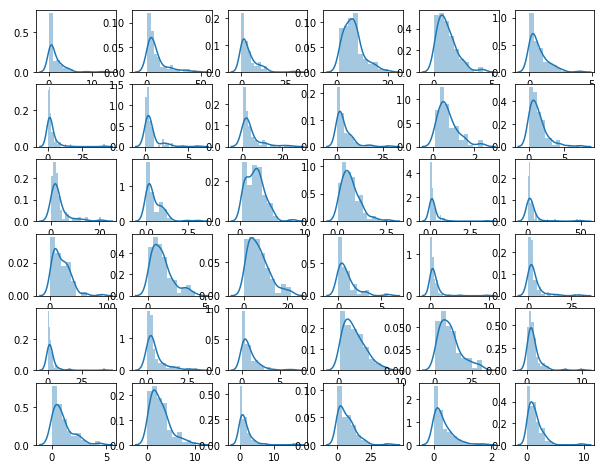

In [103]:
X, _ = generate_data(36, 100, to_tensor=False)

f, axarr = plt.subplots(6, 6, figsize=(10, 8))

for i in range(36):
    sns.distplot(X[i], ax=axarr.flat[i])
f.tight_layout()

# Training parameters

In [169]:
nn_params = dict(n_models=3, inv_h_dim=32, n_dense_inv=2, n_equiv=2)
n_post_samples = 1000
n_points = 20
n_test = 300
epochs = 20
batch_size = 64
learning_rate = 0.0005
iterations_per_epoch = 500
clip_value = 5.
global_step = tfe.Variable(0, dtype=tf.int32)
annealing_step = tfe.Variable(5000, dtype=tf.int32)
data_gen = partial(generate_data, n_points=n_points)

## Create test

In [170]:
X_test, m_test = data_gen(n_test)

## Create model and optimizer

In [171]:
model = ModelSelector(**nn_params)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Manage checkpoints

In [172]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/toy2_edl', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


## Run training loop

In [179]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:

        train_loop_online(model, optimizer, data_gen, iterations_per_epoch, batch_size, X_test, m_test, 
                          p_bar, global_step=global_step, annealing_step=annealing_step, clip_value=clip_value)
   
        manager.save()

# Evaluate performance

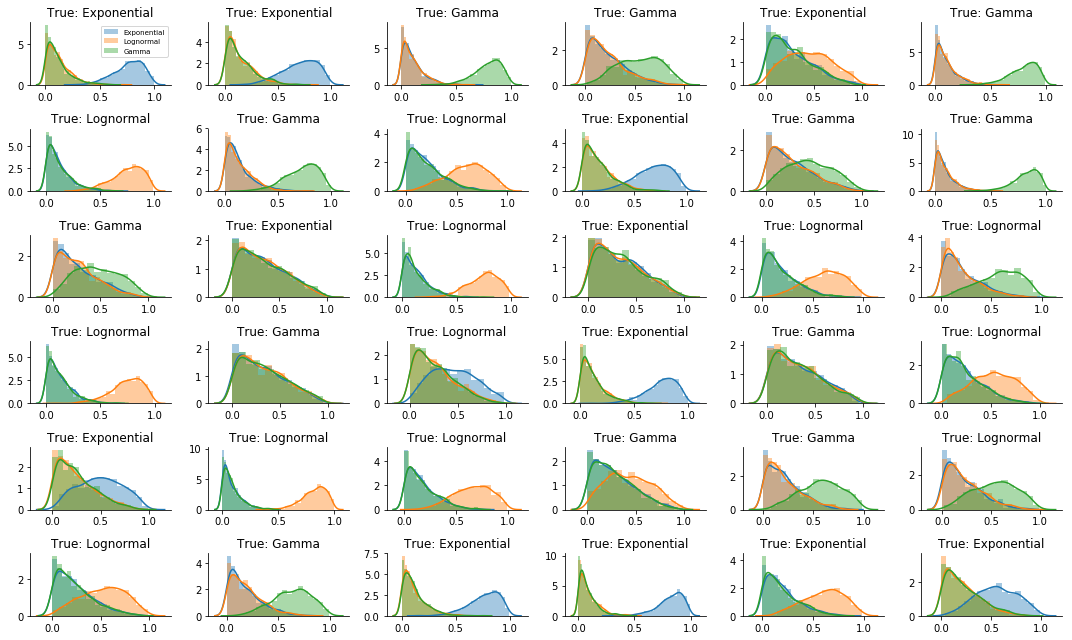

In [260]:
plot_dirichlet_samples(model, data_gen, 1000, ['Exponential', 'Lognormal', 'Gamma'])